In [11]:
import re

import numpy as np
import numpy.linalg as la

import math

import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

In [12]:
# считываем собранные с датчика данные из файла

all_lines = []
with open('MAGN.txt', "r") as f:
    all_lines = f.readlines() # readlines() возвращает список строк файла
N = 400 # кол-во точек, которые будем использовать
data_lines = []
for i in range(30, N + 30): # начинаем с 30 строки, т.к. в начале файла может находиться несущественная информация
    data_lines.append(re.split('\s+', all_lines[i]))
    data_lines[i - 30] = data_lines[i - 30][:-1]
    print(data_lines[i - 30])

['42', '-375', '-192']
['59', '-344', '-97']
['33', '-268', '-13']
['0', '-139', '16']
['0', '-139', '16']
['-27', '-21', '-26']
['-27', '44', '-102']
['-32', '83', '-175']
['-51', '78', '-274']
['-74', '29', '-393']
['-70', '-64', '-443']
['-70', '-64', '-443']
['-69', '-147', '-466']
['-68', '-184', '-469']
['-79', '-255', '-434']
['-91', '-303', '-378']
['-80', '-344', '-351']
['-49', '-377', '-264']
['-28', '-380', '-207']
['-14', '-372', '-145']
['-14', '-372', '-145']
['2', '-343', '-86']
['19', '-270', '-13']
['12', '-207', '12']
['2', '-91', '28']
['-5', '-5', '-26']
['-22', '79', '-125']
['-22', '79', '-125']
['-26', '81', '-147']
['-10', '49', '-69']
['36', '-145', '32']
['25', '-266', '-13']
['13', '-368', '-163']
['12', '-359', '-324']
['12', '-359', '-324']
['-8', '-342', '-367']
['-8', '-306', '-417']
['-22', '-248', '-447']
['-36', '-172', '-477']
['-35', '-99', '-464']
['-47', '-11', '-408']
['-47', '-11', '-408']
['-59', '30', '-356']
['-48', '75', '-287']
['-42', '77'

In [13]:
# преобразуем данные к типу float

points = []
for i in range(N):
    points.append(list(float(value) for value in data_lines[i]))

points = np.array(points)
print(points)

[[  42. -375. -192.]
 [  59. -344.  -97.]
 [  33. -268.  -13.]
 ...
 [-172. -108.  -63.]
 [  32.  -13.   -6.]
 [  32.  -13.   -6.]]


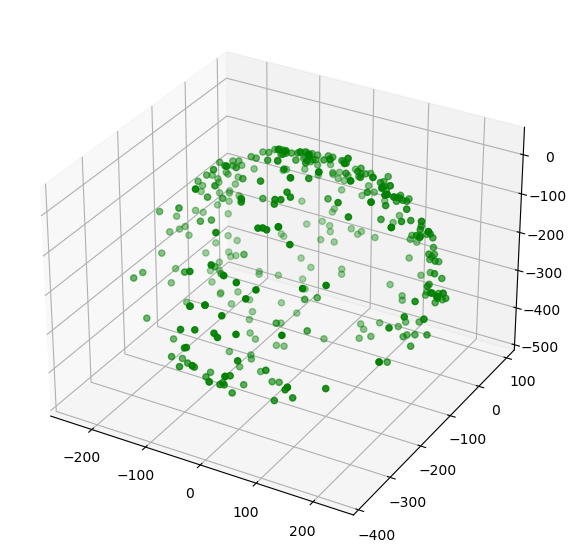

In [14]:
# точки на трехмерном графике

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, color = "green")
#plt.title("simple 3D scatter plot")

plt.show()

In [15]:
# уберем шумы

In [16]:
# точки хорошо аппроксимируются эллипсоидом, но его центр может быть сдвинут относительно начала координат
# кроме того, эллипсоид может быть повернут (т.е. его оси могут быть не параллельны координатным осям датчика)
# при этом, если эллипсоид не повернут или повернут не очень сильно, лучше использовать другой способ аппроксимации (flag = 1)
# общее уравнение:
# aX^2 + bY^2 + cZ^2 + d2XY + e2XZ + f2YZ + g2X + h2Y + i2Z = 1 
# надо найти 9 неизвестных коэффициентов:
# v = [a, b, c, d, e, f, g, h, i] 

def ellipsoid_fit(points, flag):
    
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    
    if flag == 0:
        D_T = np.array([x*x, y*y, z*z, 2*x*y, 2*x*z, 2*y*z, 2*x, 2*y, 2*z]) # транспонированная матрица D
    elif flag == 1:
        D_T = np.array([x*x, y*y, z*z, 2*x, 2*y, 2*z])
    else:
        D_T = np.array([x*x + y*y + z*z, 2*x, 2*y, 2*z])
        
    D = np.transpose(D_T) # матрица для вычисления v
    v = np.dot(la.inv(np.dot(D_T, D)), D_T.dot(np.ones((N, 1)))) # столбец неизвестных
    
    if flag == 0: # повернутый эллипсоид
        
        v_new = []
        v = [elem[0] for elem in v]
        for i in v:
            v_new.append(i)
        v = np.array(v_new)
        
        A = np.array([[v[0], v[3], v[4], v[6]], [v[3], v[1], v[5], v[7]], [v[4], v[5], v[2], v[8]], [v[6], v[7], v[8], -1.0]]) # вспомогательная 
        A = A.astype('float64')
        
        ofs = -np.dot(la.inv(A[:3,:3]), v[6:]) # смещение центра эллипсоида
        T = np.eye(4) # вспомогательная матрица
        T[3, :3] = np.transpose(ofs)
        B = np.dot(T, A.dot(np.transpose(T))) # эллипсоид, переведенный в начало координат
        eigenvalues, eigenvectors = la.eig(-B[:3, :3]/B[3, 3]) # находим собственные числа и собственные векторы матрицы в скобках
        Rot = np.transpose(eigenvectors) # матрица поворота эллипсоида
        gains = np.array([math.sqrt(1/eigenvalues[i]) for i in range(3)]) # смещения это полуоси эллипсоида
    elif flag == 1: # не повернутый эллипсоид
        ofs = np.array([v[3]/v[0], v[4]/v[1], v[5]/v[2]])
        g = 1 + (v[3])**2/v[0] + (v[4])**2/v[1] + (v[5])**2/v[2]
        gains = np.array([math.sqrt(v[0]/g), math.sqrt(v[1]/g), math.sqrt(v[2]/g)])
        Rot = np.eye(3)
    else: # сфера
        ofs = np.array([v[1]/v[0], v[2]/v[0], v[3]/v[0]])
        g = 1 + (v[1])**2/v[0] + (v[2])**2/v[0] + (v[3])**2/v[0]
        gains = np.array([math.sqrt(v[0]/g), math.sqrt(v[0]/g), math.sqrt(v[0]/g)])
        Rot = np.eye(3)
    return ofs, gains, Rot

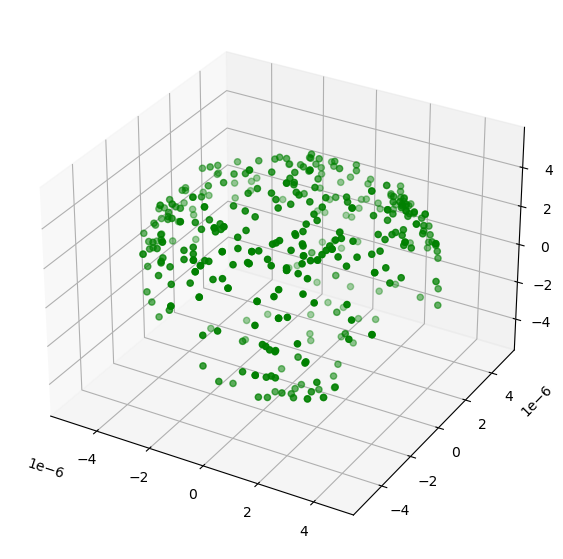

In [17]:
[ofs, gains, Rot] = ellipsoid_fit(points, 0)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# перенос в начало координат
x_c = x - ofs[0]
y_c = y - ofs[1]
z_c = z - ofs[2]

a = np.transpose(np.array([x_c, y_c, z_c]))

# поворот
xyz_c = np.dot(a, la.inv(Rot))

refr = 5*10**(-6) # эталонный радиус
x_c = (xyz_c[:, 0]/gains[0])*refr
y_c = (xyz_c[:, 1]/gains[1])*refr
z_c = (xyz_c[:, 2]/gains[2])*refr
points_new = np.transpose(np.array([x_c, y_c, z_c]))

# точки на трехмерном графике

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x_c, y_c, z_c, color = "green")
#plt.title("simple 3D scatter plot")

plt.show()

In [18]:
import pandas as pd

# for plotly graphics (alternative to matplotlib method)

import plotly
from plotly.graph_objs import Scatter, Layout, Figure, Data, Stream, YAxis, Marker, Surface
from plotly.offline import init_notebook_mode, plot, iplot

import chart_studio.plotly.plotly as py
import plotly.graph_objects as go

def scatter_graph(points, sc_color):
    x, y, z = [points[:,i] for i in [0,1,2]]
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        marker=dict(opacity=0.9,
                            reversescale=True,
                            colorscale='Blues',
                            size=3),
                    line=dict (width=0.02),
                    mode='markers'
    )
    return trace


# фунция для формирования сферы в виде графического объекта

def sphere_graph(x0,y0,z0,R):
    theta = np.linspace(0,2*np.pi,100)
    phi = np.linspace(0,np.pi,100)
    x = R*np.outer(np.cos(theta),np.sin(phi))+x0
    y = R*np.outer(np.sin(theta),np.sin(phi))+y0
    z = R*np.outer(np.ones(100),np.cos(phi))+z0
    spheredata = Data([
        Surface(
            x=x,
            y=y,
            z=z,
            opacity=0.4
        )
    ])
    return spheredata[0]
    



# фунция для формирования эллипсоида в виде графического объекта
def ellipsoid_graph(x0,y0,z0,a,b,c):
    theta = np.linspace(0,2*np.pi,100)
    phi = np.linspace(0,np.pi,100)
    x = a*np.outer(np.cos(theta),np.sin(phi))+x0
    y = b*np.outer(np.sin(theta),np.sin(phi))+y0
    z = c*np.outer(np.ones(100),np.cos(phi))+z0
    ellipsoiddata = Data([
        Surface(
            x=x,
            y=y,
            z=z,
            opacity=0.4
        )
    ])
    return ellipsoiddata[0]


# функция для отрисовки нескольких графических объектов вместе
def show_graphs(graphs_data):
    #data = [trace1, spheredata[0]]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    plotly.offline.init_notebook_mode(connected=True)
    fig = go.Figure(data=graphs_data, layout=layout)
    plotly.offline.iplot(fig, filename='simple-3d-scatter.html')

ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [19]:
sc_color='rgb(50, 50, 50)'

show_graphs(Data([scatter_graph(points_new, sc_color)]))

NameError: name 'show_graphs' is not defined

In [20]:
show_graphs([scatter_graph(points_new,sc_color),sphere_graph(0,0,0,refr)])

NameError: name 'show_graphs' is not defined

In [21]:
print(ofs)

[  -4.66872191 -148.29677101 -224.90469365]
